In [8]:
%load_ext autoreload
%autoreload 2

import fnmatch
import os
import random
import shutil
import string
import time
from abc import abstractmethod
from collections import defaultdict
from time import sleep

import numpy as np
import monai
from monai.transforms import AddChannel, Compose, Resize, ScaleIntensity, ToTensor
from torch.utils.data import DataLoader, Dataset
from datasets.numpydatasets import Numpy2dDataSet, Numpy3dDataSet
from datasets.cyclegan import CycleGANDataset
import torchvision.transforms as transforms


def get_transforms_2d(target_size=128):
    """Returns a Transform which resizes 2D samples (1xHxW) to a target_size (1 x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
    Returns:
        [Transform]
    """

    transforms = Compose([Resize((target_size, target_size)), ToTensor()])
    return transforms


def get_transforms_3d(target_size=128):
    """Returns a Transform which resizes 3D samples (1xZxYxX) to a target_size (1 x target_size x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
    Returns:
        [Transform]
    """
    transforms = Compose([Resize((target_size, target_size, target_size)), ToTensor()])
    return transforms


def get_numpy2d_dataset(
    base_dir,
    mode="train",
    batch_size=16,
    n_items=None,
    pin_memory=False,
    num_processes=1,
    drop_last=False,
    target_size=512,
    file_pattern="*data.npy",
    do_reshuffle=True,
    slice_offset=0,
    caching=True,
):
    """Returns a Pytorch data loader which loads a Numpy2dDataSet, i.e. 2D slices from a dir of 3D Numpy arrays.
    Args:
        base_dir ([str]): [Directory in which the npy files are.]
        mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
        batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
        n_items ([int], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
        pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
        num_processes (int, optional): [See pytorch DataLoader]. Defaults to 1.
        drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
        target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 128.
        file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        do_reshuffle (bool, optional): [See pytorch DataLoader]. Defaults to True.
        slice_offset (int, optinal): [Offset for the first dimension to skip the first/last n slices]. Defaults to 0.
        caching (bool, optinal): [If True saves the data set list to a file in the base_dir
                                    so files don't have to be indexed again and can be more quickly loaded using the cache file]. Defaults to True.
    Returns:
        [DataLoader]: Pytorch data loader which loads a Numpy2dDataSet
    """

    transforms = get_transforms_2d(target_size=target_size)

    data_set = Numpy2dDataSet(
        base_dir=base_dir,
        mode=mode,
        n_items=n_items,
        file_pattern=file_pattern,
        slice_offset=slice_offset,
        caching=caching,
        transforms=transforms,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=do_reshuffle,
        num_workers=num_processes,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return data_loader


def get_numpy3d_dataset(
    base_dir,
    mode="train",
    batch_size=16,
    n_items=None,
    pin_memory=False,
    num_processes=1,
    drop_last=False,
    target_size=128,
    file_pattern="*data.npy",
    do_reshuffle=False,
):
    """Returns a Pytorch data loader which loads a Numpy3dDataSet, i.e. 3D Numpy arrays from a directory.
    Args:
        base_dir ([str]): [Directory in which the npy files are.]
        mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
        batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
        n_items ([int], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
        pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
        num_processes (int, optional): [See pytorch DataLoader]. Defaults to 1.
        drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
        target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 128.
        file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        do_reshuffle (bool, optional): [See pytorch DataLoader]. Defaults to True.
    Returns:
        [DataLoader]: Pytorch data loader which loads a Numpy3dDataSet
    """

    transforms = get_transforms_3d(target_size=target_size)

    data_set = Numpy3dDataSet(
        base_dir=base_dir, mode=mode, n_items=n_items, file_pattern=file_pattern, transforms=transforms,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        #shuffle=do_reshuffle,
        num_workers=num_processes,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return data_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from torch.utils.data.dataloader import DataLoader
from datasets import DatasetType
from datasets import DATASETS
from transforms import TRANSFORMS
with open('train_example.yaml', 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)




dataset_type = config['train_dataset']['dataset_type']
dataset_kwargs = config['train_dataset']['dataset_kwargs']
transform_kwargs = config['train_dataset']['transform_kwargs']




transform = TRANSFORMS[DatasetType[dataset_type]](**transform_kwargs)
dataset = DATASETS[DatasetType['numpy2d']](
    transform=transform,
    **dataset_kwargs
)

dl = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True, pin_memory=False)

next(iter(dl)).shape

In [123]:
mean = 0.0
meansq = 0.0
count = 0
from functools import reduce
for index, data in enumerate(dl):
    #mean= reduce((lambda x, y: x + y), data)
    mean = data.sum()
    #inter = reduce((lambda x, y: x**2 + y), data)
    meansq = meansq + (data**2).sum()
    count += np.prod(data.shape)

In [124]:
total_mean = mean/count
total_var = (meansq/count) - (total_mean**2)
total_std = torch.sqrt(total_var)

In [125]:
total_mean, total_var, total_std

(tensor(0.0081), tensor(0.0758), tensor(0.2753))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(384, 384, 40)
[1. 1. 1. ... 1. 1. 1.]
16
17
18
19
20
21
22
23
24
25
26
27
28
29


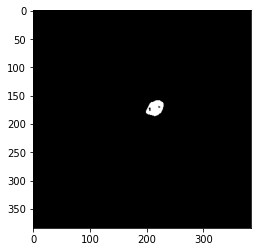

In [19]:
%load_ext autoreload
%autoreload 2

from skimage import data
from matplotlib import pyplot as plt
# import napari
import numpy as np
import PIL
import nibabel as nib
import torch
from utils.helper import read_nii_file
from matplotlib import pyplot
input_dir = r"/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/ST_labels_Task001/crossmoda2021_ldn_107_Label.nii.gz"

res = nib.load(f'{input_dir}')
np_data = res.get_fdata()

img_dir = r"/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/ST_labels_Task001/crossmoda2021_ldn_110_Label.nii.gz"
res_img = nib.load(f'{img_dir}')
np_data_img = res_img.get_fdata()

anw = np.array(res)
print(res.shape)
# print(res_img.shape)
torch.set_printoptions(profile="full")

arr = np_data[:,:,18]
arr_img = np_data_img[:,:,18]

print(np_data[np_data > 0])

for i in range(np_data.shape[2]):
    slice = np_data[:,:,i]
    if slice[slice > 0].any():
        print(i)



plt.imshow(arr, cmap='gray')

plt.show()


# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(arr_img, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(arr_img, 'gray', interpolation='none')
# plt.imshow(arr, 'jet', interpolation='none', alpha=0.7)
# plt.show()




In [7]:
import nibabel as nib

complete_input_folder = sorted(os.listdir('/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/ST_labels_Task007/'))
cnt = 0
tot = 0
for fname in complete_input_folder:
        tot += 1
        res = nib.load(f'/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/ST_labels_Task007/{fname}')
        np_data = res.get_fdata()
        if(np_data[np_data > 0].any()):
                cnt += 1
print(f'{cnt}/{tot}')

247/274


In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *
from nnunet.dataset_conversion.utils import generate_dataset_json
from nnunet.paths import nnUNet_raw_data, preprocessing_output_dir
from nnunet.utilities.file_conversions import convert_2d_image_to_nifti
import os

task_name = 'Task009_Final'
target_base = join('/dss/dssmcmlfs01/pn69za/pn69za-dss-0002/ra49tad2/nnunet_folder/nnUNet_raw_data', task_name)
target_imagesTr = join(target_base, "imagesTr").replace("\r", "")
target_imagesTs = join(target_base, "imagesTs").replace("\r", "")
target_labelsTs = join(target_base, "labelsTs").replace("\r", "")
target_labelsTr = join(target_base, "labelsTr").replace("\r", "")

# print(os.path.join(nnUNet_raw_data, task_name))
generate_dataset_json(join(target_base, 'dataset.json').replace("\r", ""), target_imagesTr, target_imagesTs, ('hrT2',),
                          labels={0: 'background', 1: 'VS', 2: 'Cochlea'}, dataset_name=task_name, license='None')



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [7]:

target_imagesTr = '/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/whole_data'

def check_modality(filename):
    """
    check for the existence of modality
    return False if modality is not found else True
    """
    end = filename.find('.nii.gz')
    modality = filename[end-4:end]
    for mod in modality: 
        if not(ord(mod)>=48 and ord(mod)<=57): #if not in 0 to 9 digits
            return False
    return True

def rename_for_single_modality(directory):
    
    for file in os.listdir(directory):
        
        if check_modality(file)==False:
            new_name = file[:file.find('.nii.gz')]+"_0000.nii.gz"
            os.rename(os.path.join(directory,file),os.path.join(directory,new_name))
            print(f"Renamed to {new_name}")
        else:
            print(f"Modality present: {file}")

rename_for_single_modality(target_imagesTr)


Modality present: crossmoda2021_ldn_11_ceT1_0000.nii.gz
Modality present: crossmoda2022_etz_68_ceT1_0000.nii.gz
Modality present: crossmoda2021_ldn_33_ceT1_0000.nii.gz
Modality present: crossmoda2022_etz_232_hrT2_0000.nii.gz
Modality present: crossmoda2021_ldn_139_hrT2_0000.nii.gz
Modality present: crossmoda2021_ldn_171_hrT2_0000.nii.gz
Modality present: crossmoda2021_ldn_144_hrT2_0000.nii.gz
Modality present: crossmoda2021_ldn_53_ceT1_0000.nii.gz
Modality present: crossmoda2021_ldn_228_hrT2_0000.nii.gz
Modality present: crossmoda2022_etz_139_hrT2_0000.nii.gz
Modality present: crossmoda2022_etz_222_hrT2_0000.nii.gz
Modality present: crossmoda2022_etz_66_ceT1_0000.nii.gz
Modality present: crossmoda2022_etz_94_ceT1_0000.nii.gz
Modality present: crossmoda2022_etz_177_hrT2_0000.nii.gz
Modality present: crossmoda2021_ldn_86_ceT1_0000.nii.gz
Modality present: crossmoda2022_etz_215_hrT2_0000.nii.gz
Modality present: crossmoda2022_etz_36_ceT1_0000.nii.gz
Modality present: crossmoda2021_ldn_100

In [8]:

target_imagesTr = '/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/ST_labels_Task007'



def rename_for_single_modality(directory):
    
    for file in os.listdir(directory):
        
        new_name = file[:file.find('.nii.gz')]+".nii.gz"
        new_name = new_name.replace("hrT2","Label")
        os.rename(os.path.join(directory,file),os.path.join(directory,new_name))
        print(f"Renamed to {new_name}")
   

rename_for_single_modality(target_imagesTr)


Renamed to crossmoda2021_ldn_168_Label.nii.gz
Renamed to crossmoda2022_etz_241_Label.nii.gz
Renamed to crossmoda2021_ldn_117_Label.nii.gz
Renamed to crossmoda2021_ldn_127_Label.nii.gz
Renamed to crossmoda2021_ldn_202_Label.nii.gz
Renamed to crossmoda2021_ldn_170_Label.nii.gz
Renamed to crossmoda2022_etz_176_Label.nii.gz
Renamed to crossmoda2022_etz_202_Label.nii.gz
Renamed to crossmoda2022_etz_218_Label.nii.gz
Renamed to crossmoda2022_etz_115_Label.nii.gz
Renamed to crossmoda2021_ldn_171_Label.nii.gz
Renamed to crossmoda2021_ldn_144_Label.nii.gz
Renamed to crossmoda2021_ldn_138_Label.nii.gz
Renamed to crossmoda2021_ldn_116_Label.nii.gz
Renamed to crossmoda2021_ldn_213_Label.nii.gz
Renamed to crossmoda2021_ldn_196_Label.nii.gz
Renamed to crossmoda2021_ldn_223_Label.nii.gz
Renamed to crossmoda2021_ldn_199_Label.nii.gz
Renamed to crossmoda2022_etz_105_Label.nii.gz
Renamed to crossmoda2021_ldn_214_Label.nii.gz
Renamed to crossmoda2021_ldn_176_Label.nii.gz
Renamed to crossmoda2021_ldn_165_L